In [ ]:
# The Julia boostrap block
# This should be run for the first time to install Julia kernel, and then refresh this page (e.g., Ctrl-R)
# so that colab will redirect to the installed Julia kernel
# and then doing your own work

# 1. install latest Julia using jill.py
#    tip: one can install specific Julia version using e.g., `jill install 1.7`
!pip install jill && jill install --upstream Official --confirm
# 2. install IJulia kernel
! julia -e 'using Pkg; pkg"add IJulia, PyPlot"; using IJulia; installkernel("Julia")'
# 3. hot-fix patch to strip the version suffix of the installed kernel so that this notebook kernelspec is version agnostic
!jupyter kernelspec install $(jupyter kernelspec list | grep julia | tr -s ' ' | cut -d' ' -f3) --replace --name julia

In [43]:
using PyPlot, LinearAlgebra, SparseArrays

function diffusion_1D_explicit(NX)
    # Nx = 41 ; # try changing this number from 41 to 81 and Run All ... what happens?
    dx = 2/(NX-1);
    NT = 20 ;   # NT is the number of timesteps we want to calculate
    nu = 0.3    # the value of viscosity
    sigma = 0.2 # sigma is a parameter, we'll learn more about it later
    dt = (sigma*(dx^2))/nu ; # dt is the amount of time each timestep covers (delta t)


    u = ones(Float64,NX);    # function ones()
    s = Int(floor(0.5/dx));
    e = Int(floor(1/dx));
    u[s:e] .= 2.0;
    un = ones(Float64,NX); # initialize a temporary array
    for n in 1:NT          # loop for values of n from 0 to nt, so it will run nt times
        un = copy(u)       # copy the existing values of u into un
        for i in 2:NX-1    # you can try commenting this line and...
            u[i] = un[i] + nu*dt/dx^2 * ( un[i+1] - 2*un[i] + un[i-1] );
        end
    end
    plot(range(0, length = NX ,stop = 2),u);
end

diffusion_1D_explicit (generic function with 1 method)

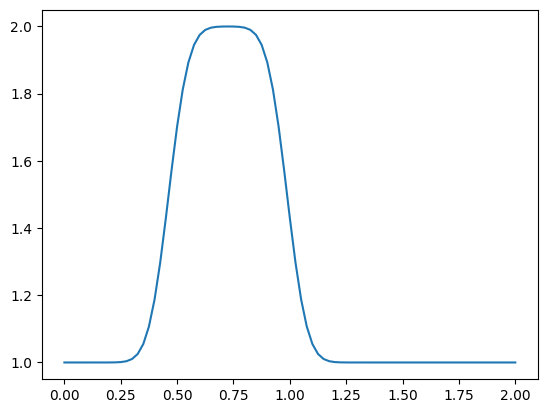

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fbf308602d0>

In [41]:
diffusion_1D_explicit(81)

In [44]:
function diffusion_1D_implicit(NX)
    # Nx = 41 ; # try changing this number from 41 to 81 and Run All ... what happens?
    dx = 2/(NX-1);
    NT = 20 ;   # NT is the number of timesteps we want to calculate
    nu = 0.3    # the value of viscosity
    sigma = 0.2 # sigma is a parameter, we'll learn more about it later
    dt = (sigma*(dx^2))/nu ; # dt is the amount of time each timestep covers (delta t)


    u = ones(Float64,NX);    # function ones()
    s = Int(floor(0.5/dx));
    e = Int(floor(1/dx));
    u[s:e] .= 2.0;
    un = ones(Float64,NX); # initialize a temporary array

    # initialize a matrix
    # diagm is the function to build diagonal matrix in std lib LinearAlgebra
    # >diagm([1,2])
    #  2×2 Matrix{Int64}:
    #     1   0
    #     0   2
    A = diagm(ones(Float64,NX));

    for row in 2:NX-1
        A[row,row-1] = -nu*dt/dx^2
        A[row,row] = 2*nu*dt/dx^2 + 1
        A[row,row+1] =  -nu*dt/dx^2
        # (u[i] - un[i])/dt = nu/dx^2 * (u[i+1] - 2*u[i] + u[i-1]);
        # then we have:
        # u[i] - nu*dt/dx^2 * (u[i+1] - 2*u[i] + u[i-1]) = un[i];
        # Au = un
    end

    for n in 1:NT          # loop for values of n from 0 to nt, so it will run nt times
        un = copy(u)       # copy the existing values of u into un
        u = A \ un         # solve linear equation, Ax=b, solve x by x = A \ b
    end
    plot(range(0, length = NX ,stop = 2),u);
end

diffusion_1D_implicit (generic function with 1 method)

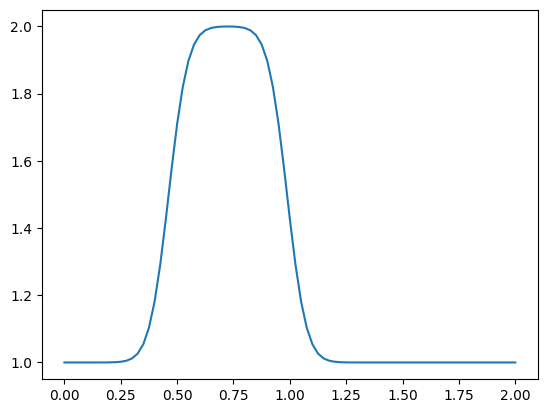

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fbf309c3510>

In [45]:
diffusion_1D_implicit(81)

$$
∂_t u = \nu Δu \\
\dfrac{u^{n+1}_i - u^n_i}{dt} = \dfrac{\nu}{dx^2} ( \theta (u^{n+1}_{i+1} - 2u^{n+1}_i + u^{n+1}_{i-1}) + (1-\theta) (u^{n}_{i+1} - 2u^{n}_i + u^{n}_{i-1})) \\
\text{let } \sigma = \dfrac{\nu dt}{dx^2}\\
u^{n+1}_{i} - \sigma \theta (u^{n+1}_{i+1} - 2u^{n+1}_i + u^{n+1}_{i-1}) = u^n_i + \sigma (1-\theta) (u^{n}_{i+1} - 2u^{n}_i + u^{n}_{i-1})
$$

$$
\mathrm{AU}=\left[\begin{array}{ccccc}
1 & 0 & & & \\
-\sigma \theta & 2\sigma \theta+1 & -\sigma \theta & & \\
& \ddots & \ddots & \ddots & \\
& & -\sigma \theta & 2\sigma \theta+1 & -\sigma \theta \\
& & & 0 & 1
\end{array}\right]\left[\begin{array}{c}
\mathrm{u}_{1} \\
\mathrm{u}_{2} \\
\vdots \\
\mathrm{u}_{\mathrm{J}-1} \\
\mathrm{u}_{\mathrm{J}}
\end{array}\right]
$$

In [47]:
function diffusion_1D_theta(NX,;theta=1/2,sigma=0.2)
    # Nx = 41 ; # try changing this number from 41 to 81 and Run All ... what happens?
    dx = 2/(NX-1);
    NT = 20 ;   # NT is the number of timesteps we want to calculate
    nu = 0.3    # the value of viscosity
    sigma = sigma # sigma is a parameter, we'll learn more about it later
    dt = (sigma*(dx^2))/nu ; # dt is the amount of time each timestep covers (delta t)


    u = ones(Float64,NX);    # function ones()
    s = Int(floor(0.5/dx));
    e = Int(floor(1/dx));
    u[s:e] .= 2.0;
    un = ones(Float64,NX); # initialize a temporary array
   
    A = diagm(ones(Float64,NX)); # initialize a matrix
    for row in 2:NX-1
        A[row,row-1] = -theta*nu*dt/dx^2
        A[row,row] = 2*theta*nu*dt/dx^2 + 1
        A[row,row+1] =  -theta*nu*dt/dx^2
        # (u[i] - un[i])/dt = nu/(dx^2) * (theta*(u[i+1] - 2*u[i] + u[i-1]) + (1-theta)*(un[i+1] - 2*un[i] + un[i-1]));
        # then we have:
        # u[i] - nu*dt/(dx^2) * theta*(u[i+1] - 2*u[i] + u[i-1]) = un[i] + nu*dt/(dx^2)(1-theta)*(un[i+1] - 2*un[i] + un[i-1]);
    end

    B = diagm(ones(Float64,NX)); # initialize a matrix
    for row in 2:NX-1
        B[row,row-1] = (1-theta)*nu*dt/dx^2
        B[row,row] = -2*(1-theta)*nu*dt/dx^2 + 1
        B[row,row+1] =  (1-theta)*nu*dt/dx^2
        # (u[i] - un[i])/dt = nu/(dx^2) * (theta*(u[i+1] - 2*u[i] + u[i-1]) + (1-theta)*(un[i+1] - 2*un[i] + un[i-1]));
        # then we have:
        # u[i] - nu*dt/(dx^2) * theta*(u[i+1] - 2*u[i] + u[i-1]) = un[i] + nu*dt/(dx^2)(1-theta)*(un[i+1] - 2*un[i] + un[i-1]);
    end

    for n in 1:NT          # loop for values of n from 0 to nt, so it will run nt times
        un = copy(u)       # copy the existing values of u into un
        u = A \ (B*un)         # solve linear equation
    end
    plot(range(0, length = NX ,stop = 2),u);
end

diffusion_1D_theta (generic function with 2 methods)

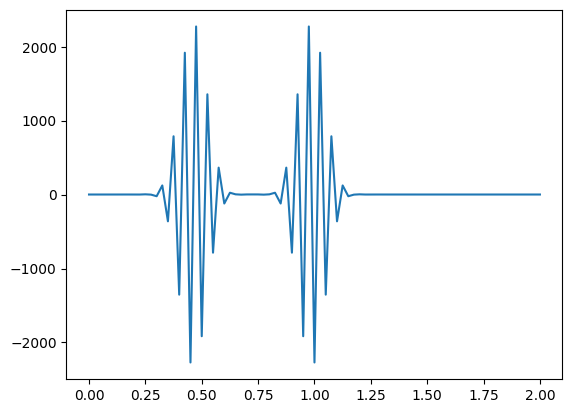

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fbf30a5b790>

In [48]:
diffusion_1D_theta(81; theta=1/4, sigma=2)

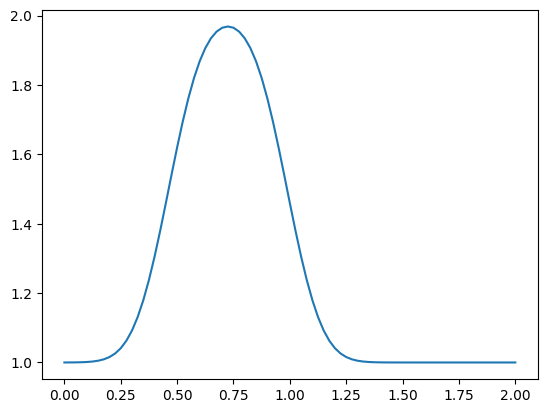

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fbf30a08210>

In [49]:
diffusion_1D_theta(81; theta=1/4, sigma=0.6)

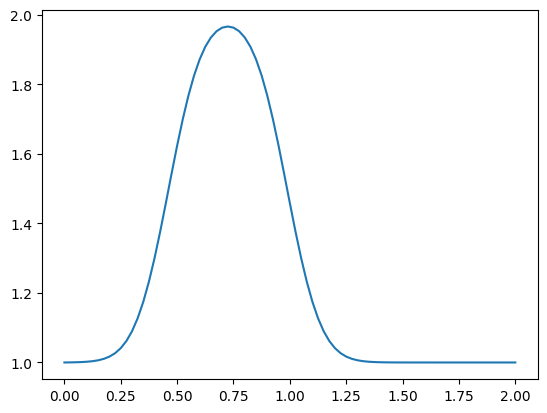

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fbf2c5b7490>

In [50]:
diffusion_1D_theta(81; theta=1, sigma=0.6) # implicit

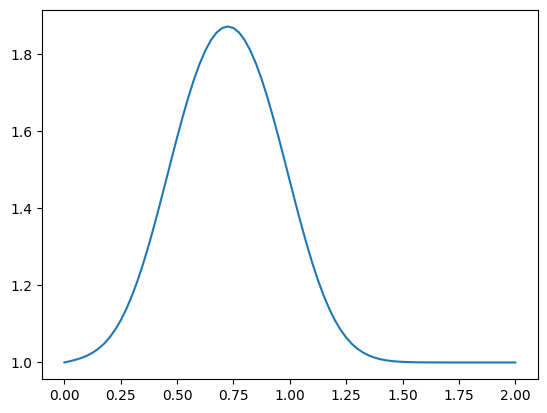

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fbf2c52a710>

In [51]:
diffusion_1D_theta(81;theta=1/2, sigma=1.2) # C-N method

In [52]:
NX = 10
theta = 1
nu = 0.3
dx = 2 / (NX - 1)
dt = (0.2*(dx^2))/nu
A = diagm(ones(Float64,NX)); # initialize a matrix
for row in 2:NX-1 # loop by row
    A[row,row-1] = -theta*nu*dt/dx^2
    A[row,row] = 2*theta*nu*dt/dx^2 + 1
    A[row,row+1] =  -theta*nu*dt/dx^2
end
sparse(A)

10×10 SparseMatrixCSC{Float64, Int64} with 26 stored entries:
  1.0    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
 -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    1.0

In [53]:
# use spdiagm, check https://docs.julialang.org/en/v1/stdlib/SparseArrays/
A = spdiagm(0 => fill(2*theta*nu*dt/dx^2+1,NX),
          -1 => fill(-theta*nu*dt/dx^2,NX-1),
           1 => fill(-theta*nu*dt/dx^2,NX-1))

10×10 SparseMatrixCSC{Float64, Int64} with 28 stored entries:
  1.4  -0.2    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
 -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -0.2   1.4

In [54]:
# change the value in 1st and last row
A[1,1] = 1
A[1,2] = 0
A[NX, NX] = 1
A[NX, NX-1] = 0
A

10×10 SparseMatrixCSC{Float64, Int64} with 28 stored entries:
  1.0   0.0    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
 -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2    ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -0.2   1.4  -0.2
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    0.0   1.0

In [ ]:
# Solving Large Sparse Linear Systems
# AU = B

# U = A \ B 
# using LU or QR factorization

# when A is large, maybe we need some iterative method, like gmres, cg
# check https://nextjournal.com/sosiris-de/pde-2018 for more details


In [58]:
# # simple Heat Equation
# We consider the heat equation on the unit interval, with Dirichlet boundary conditions:
# ∂ₜu = Δu
# u(x=0,t)  = a
# u(x=1,t)  = b
# u(x, t=0) = u₀(x)
#
# For `a = b = 0` and `u₀(x) = sin(2πx)` a solution is given by:
# note that `a = b = 0`, so u(x,t) at boundary always equals 0
using SparseArrays
u_analytic(x, t) = sin(2*π*x) * exp(-t*(2*π)^2)

function solve_heat(;theta=1.0, sigma=0.1)
    Δx = 0.01
    x = Δx:Δx:1-Δx # we dont need the point x=0 and x=1 here
    N = length(x)
    t0 = 0.0
    t1 = 0.03
    Δt = sigma*Δx^2
    u0 = u_analytic.(x, t0)

    A = spdiagm(0=>(1+2*sigma*theta)*ones(N), -1=>-sigma*theta*ones(N-1), 1=>-sigma*theta*ones(N-1))
    B = spdiagm(0=>(1-2*sigma*(1-theta))*ones(N), -1=>sigma*(1-theta)*ones(N-1), 1=>sigma*(1-theta)*ones(N-1))

    u_next = copy(u0)

    for i in Δt:Δt:t1
        u_next = A \ (B*u_next)
    end
    u_T = u_next

    plot(range(Δx, length = N ,stop = 1-Δx),u0,label="t=0,numerical")
    plot(range(Δx, length = N ,stop = 1-Δx),u_analytic.(x,t0),":",label="t=0,analytic")

    plot(range(Δx, length = N ,stop = 1-Δx),u_T,label="t=0.03,numerical")
    plot(range(Δx, length = N ,stop = 1-Δx),u_analytic.(x,t1),":",label="t=0.03,analytic")
    legend()
    return u_T
end



solve_heat (generic function with 1 method)

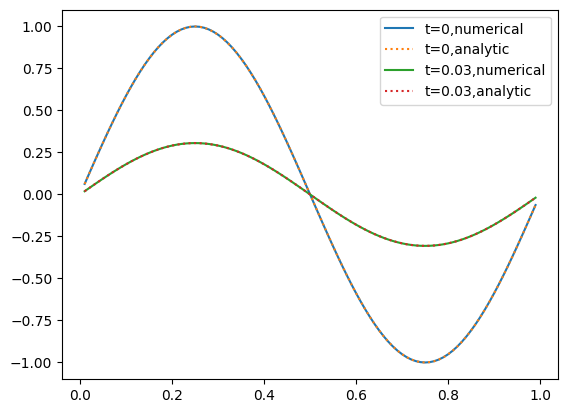

99-element Vector{Float64}:
  0.019213390668710875
  0.0383509548622156
  0.0573371653577638
  0.07609709225650405
  0.0945566986975624
  0.11264313304770798
  0.1302850164134666
  0.1474127243410035
  0.16395866159203412
  0.17985752891134837
  0.19504658073313838
  0.20946587280908138
  0.2230584987809014
  ⋮
 -0.20946587280908163
 -0.19504658073313866
 -0.17985752891134865
 -0.16395866159203445
 -0.14741272434100383
 -0.13028501641346693
 -0.11264313304770826
 -0.09455669869756268
 -0.07609709225650427
 -0.05733716535776397
 -0.038350954862215694
 -0.01921339066871093

In [62]:
solve_heat(;theta=0, sigma=0.1) #explicit